<a href="https://www.kaggle.com/code/loananh/linear-regression?scriptVersionId=227353471" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Prepare Python Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

# Load Dataframe
data = pd.read_csv('/kaggle/input/hose-market/CafeF.HSX.Upto07.03.2025.csv')

# Rename column <DTYYYYMMDD> to Date
data.rename(columns={'<DTYYYYMMDD>': '<Date>'}, inplace=True)

# Convert <DTYYYYMMDD> from number to date format
data['<Date>'] = pd.to_datetime(data['<Date>'], format='%Y%m%d')

# Filter Stock Data for Analytics (SSI Stock in 8 years)
start_date = datetime.now()
end_date = start_date - pd.DateOffset(years=8)
df = data[(data['<Ticker>']=='SSI') & (data['<Date>'] >= end_date) & (data['<Date>'] <= start_date)]

# Sort date and index in ascending
df = df.iloc[::-1]
df = df.reset_index(drop = True, inplace = False)

print(df.head())
print(df.tail())

#Get the duration of data set
print("Starting date: ", df.iloc[0]['<Date>'])
print("Ending date: ", df.iloc[-1]['<Date>'])
print("Duration: ", df.iloc[-1]['<Date>'] - df.iloc[0]['<Date>'])

  <Ticker>     <Date>  <Open>  <High>   <Low>  <Close>  <Volume>
0      SSI 2017-03-14  7.0742  7.1237  7.0577   7.0590   1093080
1      SSI 2017-03-15  7.0247  7.0742  6.9918   7.0260   1195640
2      SSI 2017-03-16  7.0083  7.3545  7.0083   7.3559   6659800
3      SSI 2017-03-17  7.4700  7.6349  7.3875   7.5043   9070330
4      SSI 2017-03-20  7.6514  7.7173  7.5524   7.5868   3333090
     <Ticker>     <Date>  <Open>  <High>  <Low>  <Close>  <Volume>
1989      SSI 2025-03-03   26.30   26.80  26.15    26.60  25645100
1990      SSI 2025-03-04   26.45   26.60  26.10    26.35  24072400
1991      SSI 2025-03-05   26.40   26.65  26.10    26.10  27564200
1992      SSI 2025-03-06   26.20   26.95  26.20    26.90  44988800
1993      SSI 2025-03-07   27.10   27.15  26.80    26.90  22896800
Starting date:  2017-03-14 00:00:00
Ending date:  2025-03-07 00:00:00
Duration:  2915 days 00:00:00



Detailed Statistical Summary:
                            OLS Regression Results                            
Dep. Variable:                <Close>   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     2533.
Date:                Thu, 13 Mar 2025   Prob (F-statistic):               0.00
Time:                        08:06:44   Log-Likelihood:                -6242.2
No. Observations:                1994   AIC:                         1.249e+04
Df Residuals:                    1992   BIC:                         1.250e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.0713

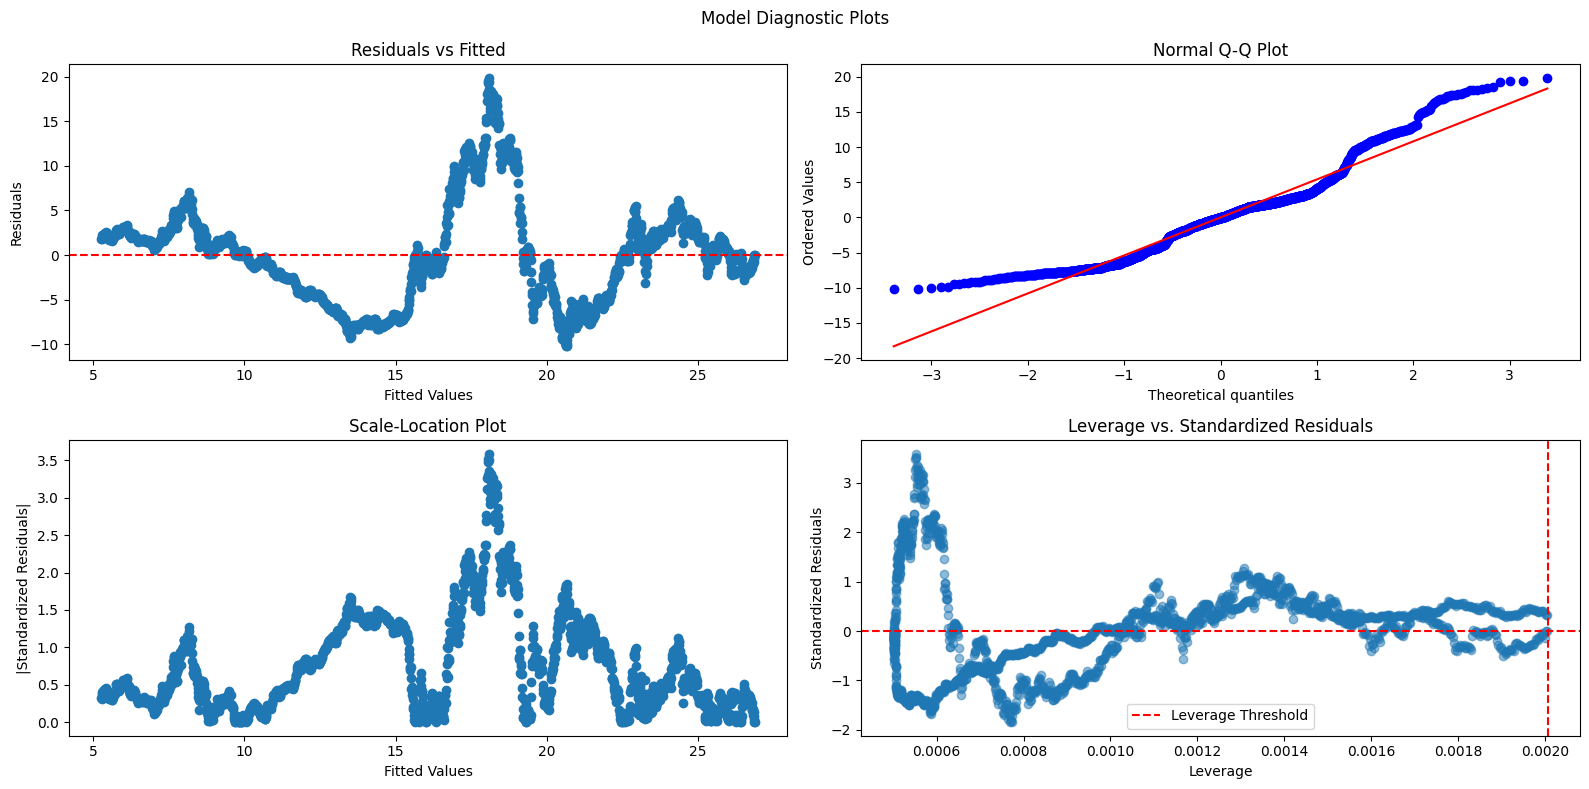

In [2]:
# Create features for prediction and standardize
df['Days'] = range(len(df))
X = df[['Days']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=['Days'])
y = df['<Close>']

# Fit Linear Regression model with scaled features
model = LinearRegression()
model.fit(X_scaled_df, y)

# Print detailed statsmodels summary with scaled features
print("\nDetailed Statistical Summary:")
X_scaled_sm = sm.add_constant(X_scaled)
sm_model = sm.OLS(y, X_scaled_sm).fit()
print(sm_model.summary())

# Add model diagnostics
residuals = sm_model.resid
fitted_values = sm_model.fittedvalues

print("\nModel Diagnostics:")
print("Durbin-Watson test (autocorrelation):", durbin_watson(residuals))
print("Breusch-Pagan test (heteroscedasticity):", het_breuschpagan(residuals, X_scaled_sm))
print("Jarque-Bera test (normality):", stats.jarque_bera(residuals))

# Add diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.suptitle('Model Diagnostic Plots')

# Residuals vs Fitted
axes[0, 0].scatter(fitted_values, residuals)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot')

# Scale-Location Plot
standardized_residuals = residuals / np.sqrt(np.sum(residuals**2) / (len(residuals)-2))
axes[1, 0].scatter(fitted_values, np.abs(standardized_residuals))
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('|Standardized Residuals|')
axes[1, 0].set_title('Scale-Location Plot')

# Calculate leverage and standardized residuals for influence plot
influence = sm_model.get_influence()
leverage = influence.hat_matrix_diag
std_residuals = sm_model.get_influence().resid_studentized_internal

# Leverage vs. Residuals Plot
axes[1, 1].scatter(leverage, std_residuals, alpha=0.5)
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].axvline(x=2*(X_scaled_sm.shape[1])/X_scaled_sm.shape[0], color='r', linestyle='--', label='Leverage Threshold')
axes[1, 1].set_xlabel('Leverage')
axes[1, 1].set_ylabel('Standardized Residuals')
axes[1, 1].set_title('Leverage vs. Standardized Residuals')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [3]:
# Create future dates for prediction (15 days)
last_date = df['<Date>'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15, freq='B')
future_days = range(len(df), len(df) + 15)

# Make predictions with scaled features
future_X = pd.DataFrame({'Days': future_days})
future_X_scaled = scaler.transform(future_X)

# Calculate confidence intervals using statsmodels
X_sm = sm.add_constant(X)
sm_model = sm.OLS(y, X_sm).fit()
future_X_sm = sm.add_constant(future_X)
forecast_ci = sm_model.get_prediction(future_X_sm).conf_int()

# Make predictions with scaled features
future_predictions = sm_model.predict(future_X_sm)

# Print forecast results
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': np.round(future_predictions, 2),
    'CI_Lower': np.round(forecast_ci[:, 0], 2),
    'CI_Upper': np.round(forecast_ci[:, 1], 2)
})
print("\nPrice Forecast for next 15 business days:")
pd.set_option('display.float_format', '{:.2f}'.format)
print(forecast_df)

# Calculate historical ROI
initial_price = df['<Close>'].iloc[0]
final_price = df['<Close>'].iloc[-1]
historical_roi = ((final_price - initial_price) / initial_price) * 100

# Calculate predicted ROI
predicted_final_price = forecast_df['Predicted_Price'].iloc[-1]
predicted_roi = ((predicted_final_price - final_price) / final_price) * 100

print("\nROI Analysis:")
print(f"Initial Price: {initial_price:.2f}")
print(f"Final Price: {final_price:.2f}")
print(f"Historical ROI: {historical_roi:.2f}%")
print(f"Current Price: {final_price:.2f}")
print(f"Predicted Final Price: {predicted_final_price:.2f}")
print(f"Predicted 15-day ROI: {predicted_roi:.2f}%")


Price Forecast for next 15 business days:
         Date  Predicted_Price  CI_Lower  CI_Upper
0  2025-03-10            26.89     26.40     27.38
1  2025-03-11            26.90     26.42     27.39
2  2025-03-12            26.91     26.43     27.40
3  2025-03-13            26.92     26.44     27.41
4  2025-03-14            26.93     26.45     27.42
5  2025-03-17            26.95     26.46     27.43
6  2025-03-18            26.96     26.47     27.45
7  2025-03-19            26.97     26.48     27.46
8  2025-03-20            26.98     26.49     27.47
9  2025-03-21            26.99     26.50     27.48
10 2025-03-24            27.00     26.51     27.49
11 2025-03-25            27.01     26.52     27.50
12 2025-03-26            27.02     26.53     27.51
13 2025-03-27            27.03     26.54     27.52
14 2025-03-28            27.04     26.55     27.54

ROI Analysis:
Initial Price: 7.06
Final Price: 26.90
Historical ROI: 281.07%
Current Price: 26.90
Predicted Final Price: 27.04
Predicted 15-

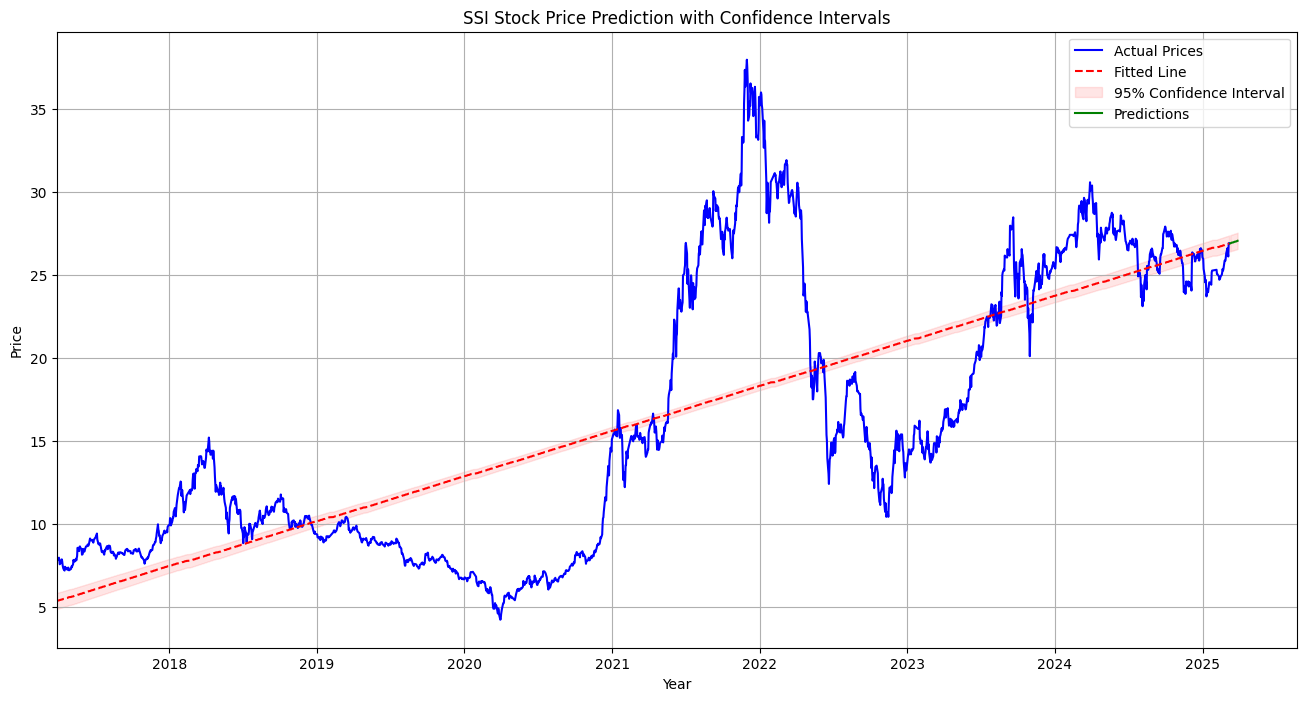

In [4]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(df['<Date>'], df['<Close>'], label='Actual Prices', color='blue')

# Generate predictions summary frame for the existing data
predictions_summary_frame = sm_model.get_prediction(X_sm).summary_frame(alpha=0.05)

plt.plot(df['<Date>'], predictions_summary_frame['mean'], 'r--', label='Fitted Line')
plt.fill_between(df['<Date>'], 
                  predictions_summary_frame['mean_ci_lower'],
                  predictions_summary_frame['mean_ci_upper'],
                  color='red', alpha=0.1, label='95% Confidence Interval')

# Future predictions with confidence intervals
future_X = sm.add_constant(future_X)
future_predictions = sm_model.get_prediction(future_X)
future_summary_frame = future_predictions.summary_frame(alpha=0.05)

plt.plot(future_dates, future_summary_frame['mean'], label='Predictions', color='green')
plt.fill_between(future_dates,
                 future_summary_frame['mean_ci_lower'],
                 future_summary_frame['mean_ci_upper'],
                 color='red', alpha=0.1)

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('SSI Stock Price Prediction with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.xlim(df['<Date>'].min() + pd.Timedelta(days=15))
plt.show()